**run_test.ipynb**

simulate the airfoil moment bench test.

Wonhee LEE

2024 JUL 20 (SAT)

reference:
- https://matplotlib.org/stable/gallery/animation/double_pendulum.html#sphx-glr-gallery-animation-double-pendulum-py

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
# from simple_pid import PID

In [2]:
import moment_bench

# set up environment

## design airfoil

In [4]:
C_l0 = 0  # symmetric aifoil (flat plate)
c = 0.2  # [m] chord
s = 1  # [m] span
mass = 30  # [kg]
moi_yy = mass * c ** 2 / 12  # [kg*m^2]
l_cm = c / 7
flap = moment_bench.Control_Surface(c=c / 3, s=0.65 * s)

airfoil = moment_bench.Airfoil(C_l0, c, s, mass, moi_yy, l_cm, flap)

## define dynamics

In [5]:
air = moment_bench.Air(density=1.225)

air_speed = 34  # [m/s] wind tunnel air speed
init_cond = moment_bench.Initial_Condition(v_a=air_speed, alpha=math.radians(5), u_f=0)

flap_limits = (math.radians(-20), math.radians(20))

dynamics = moment_bench.Dynamics(airfoil, air, init_cond, flap_limits, g=9.81)

In [6]:
print("initial condition:")
print(f"\tv_a  : {init_cond.v_a} [m/s]\n\
        alpha: {math.degrees(init_cond.alpha)} [deg]\n\
        u_f  : {math.degrees(init_cond.u_f)} [deg]")
print(f"flap limits: ({math.degrees(flap_limits[0])}, {math.degrees(flap_limits[1])})")

initial condition:
	v_a  : 34 [m/s]
        alpha: 5.0 [deg]
        u_f  : 0.0 [deg]
flap limits: (-20.0, 20.0)


In [7]:
env = moment_bench.Environment(dynamics)

## check

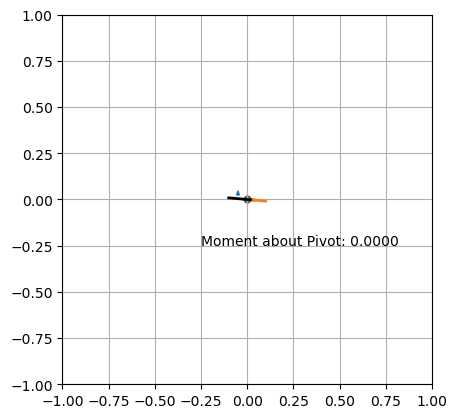

In [8]:
env.render()

# set up controller

In [9]:
# controller = PID(0.001, 0.0005, 0.00005, setpoint=0)

In [10]:
class My_PID:
    """
    author: ChatGPT
    """
    def __init__(self, Kp, Ki, Kd, setpoint=0):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.setpoint = setpoint
        self.integral = 0
        self.previous_error = 0

    def update(self, measurement, dt):
        # Calculate error
        error = self.setpoint - measurement

        # Proportional term
        P = self.Kp * error

        # Integral term
        self.integral += error * dt
        I = self.Ki * self.integral

        # Derivative term
        derivative = (error - self.previous_error) / dt
        D = self.Kd * derivative

        # Update previous error
        self.previous_error = error

        # PID output
        output = P + I + D

        return output

In [11]:
controller = My_PID(0.02, 0.05, 0.001, setpoint=0)

# run simulation

In [12]:
env.reset()

In [13]:
max_num_steps = 10000
delta_t = 1E-1

In [14]:
def run_simulation(delta_t, do_render=False):
    Mm, _, _, _, _ = env.step(action=init_cond.u_f)
    # print(f"initial pitching moment about the pivot: {Mm:.4F} [Nm]")

    t = 0
    delta_t = 1E-1  # [s]
    ts = [t]
    state_trajectory = [Mm]
    control_trajectory = [init_cond.u_f]
    fm_trajectory = [[env.dynamics.L, env.dynamics.Mm]]

    for i in range(max_num_steps):
        u_f = controller.update(Mm, dt=delta_t)
        Mm, _, _, _, _ = env.step(u_f)
    
        t += delta_t
        ts.append(t)
        state_trajectory.append(Mm)
        control_trajectory.append(u_f)
        fm_trajectory.append([env.dynamics.L, env.dynamics.Mm])
    
        if abs(Mm) < 1E-3:
            print("setpoint reached")
            if do_render: env.render()
            break

        if i % 100 == 0:
            if do_render: env.render()
    
    ts = np.array(ts)
    state_trajectory = np.array(state_trajectory)
    control_trajectory = np.array(control_trajectory)
    fm_trajectory = np.array(fm_trajectory)

    return ts, state_trajectory, control_trajectory, fm_trajectory

In [15]:
ts, state_trajectory, control_trajectory, fm_trajectory = run_simulation(delta_t)

setpoint reached


## result

In [23]:
print(f"moment about pivot: {state_trajectory[-1]:.7F} [Nm], flap deflection: {math.degrees(control_trajectory[-1]):.4F} [deg]")

moment about pivot: -0.0009332 [Nm], flap deflection: 13.0966 [deg]


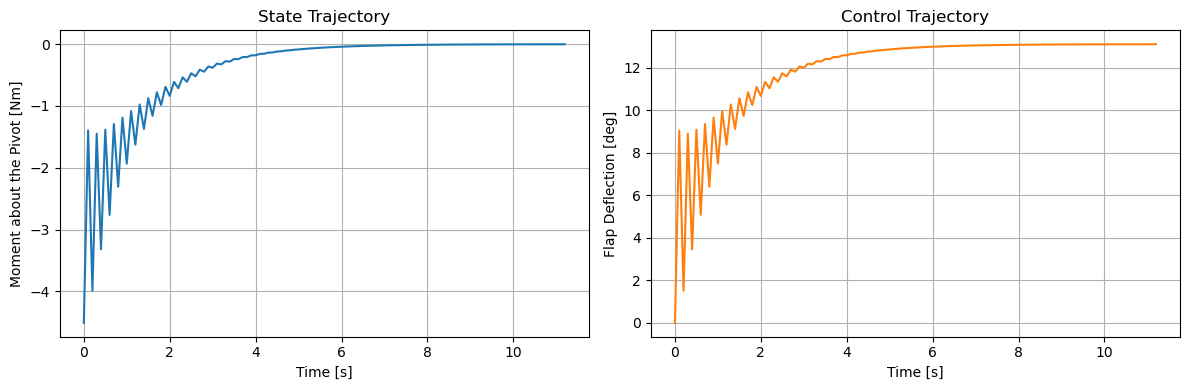

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(ts, state_trajectory, color=plt.cm.tab10(0))
axes[0].set_xlabel("Time [s]")
axes[0].set_ylabel("Moment about the Pivot [Nm]")
axes[0].set_title("State Trajectory")
axes[0].grid()

axes[1].plot(ts, np.rad2deg(control_trajectory), color=plt.cm.tab10(1))
axes[1].set_xlabel("Time [s]")
axes[1].set_ylabel("Flap Deflection [deg]")
axes[1].set_title("Control Trajectory")
axes[1].grid()

plt.tight_layout() 
plt.show()

In [18]:
from functools import partial

In [19]:
def max_abs_scaler(X):
    max_abs_values = np.max(np.abs(X), axis=0)
    return X / max_abs_values

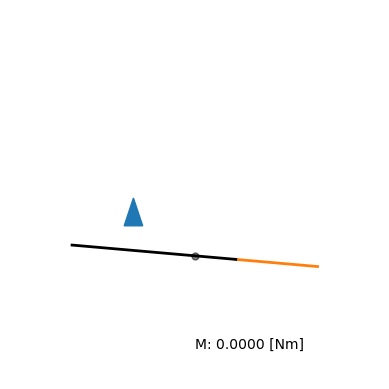

In [24]:
dynamics.reset()

fig, ax = plt.subplots()
# plt.grid()
plt.axis("off")
plt.xlim(-0.15, 0.15)
plt.ylim(-0.1, 0.2)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
assets = dynamics.initialize_figure(ax)

# scale lift for drawing purpose:
scaled_lifts = 0.1 * max_abs_scaler(fm_trajectory[:, 0]).reshape(-1, 1)
scaled_fm_trajectory = np.hstack((scaled_lifts, fm_trajectory[:, 1].reshape(-1, 1)))

# create animation
trajectories = (ts, state_trajectory, control_trajectory, scaled_fm_trajectory)
FuncAnimation = partial(FuncAnimation, fargs=(assets, trajectories))

ani = FuncAnimation(fig, dynamics.animate, frames=len(ts), interval=delta_t * 1E3)
plt.show()

In [21]:
from IPython.display import HTML
HTML(ani.to_html5_video())